In [171]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns

pd.options.display.float_format = '{:,.3f}'.format

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.dates import AutoDateFormatter, AutoDateLocator, YearLocator
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.dates as mdates
%matplotlib inline

# Univariate Plots

In [128]:
# load the dataset
#df = pd.read_csv("export-verified-contracts.csv",sep=",")
df = pd.read_csv("export-NetworkUtilization.csv",sep=",")

In [129]:
#reformat column names to non-unique, as the axis labels can always be renamed later
df["Date(UTC)"] = pd.to_datetime(df["Date(UTC)"])
df.columns = ["Date","TimeStamp","Value"]
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.week

Text(0, 0.5, 'This can be renamed')

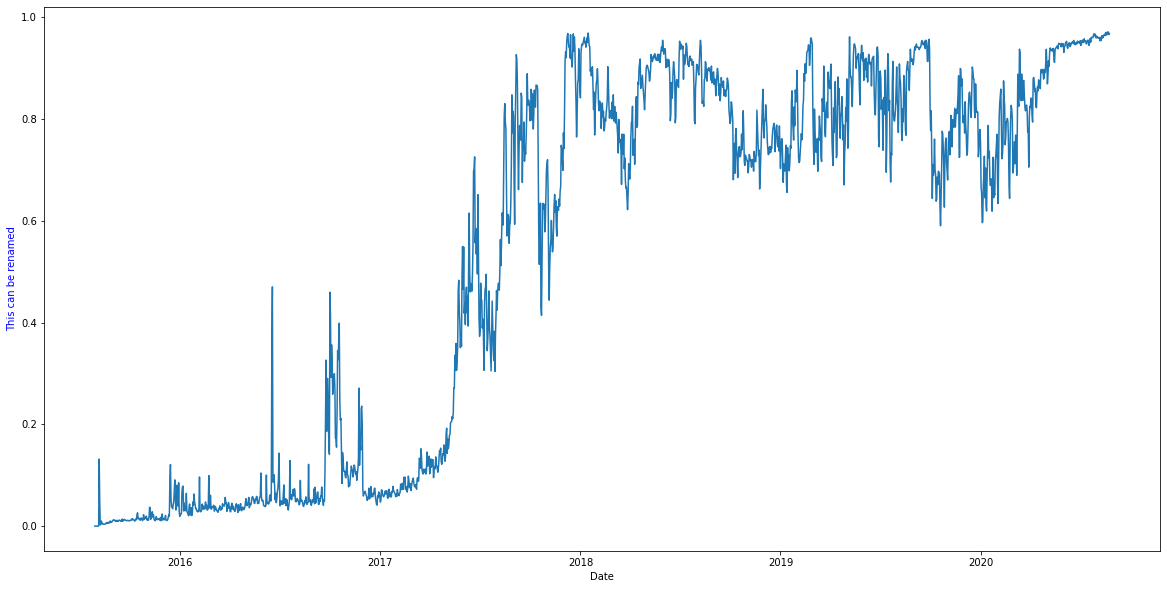

In [130]:
# time series plot
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(x="Date", y="Value", data=df)
ax.set_ylabel('This can be renamed', color='b')

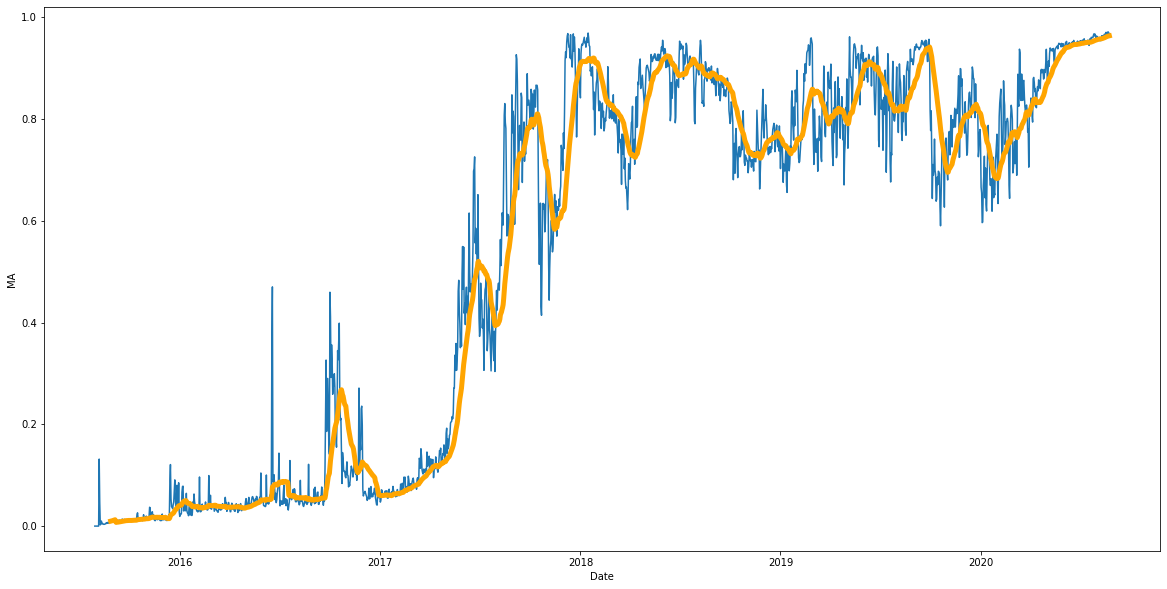

In [131]:
# time series with moving average (30 days)
plot_df = df.copy()
plot_df["MA"] = plot_df["Value"].rolling(30).mean() 
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(x="Date", y="Value", data=plot_df)
ax = sns.lineplot(x="Date", y="MA", data=plot_df, linewidth=5, color="orange")

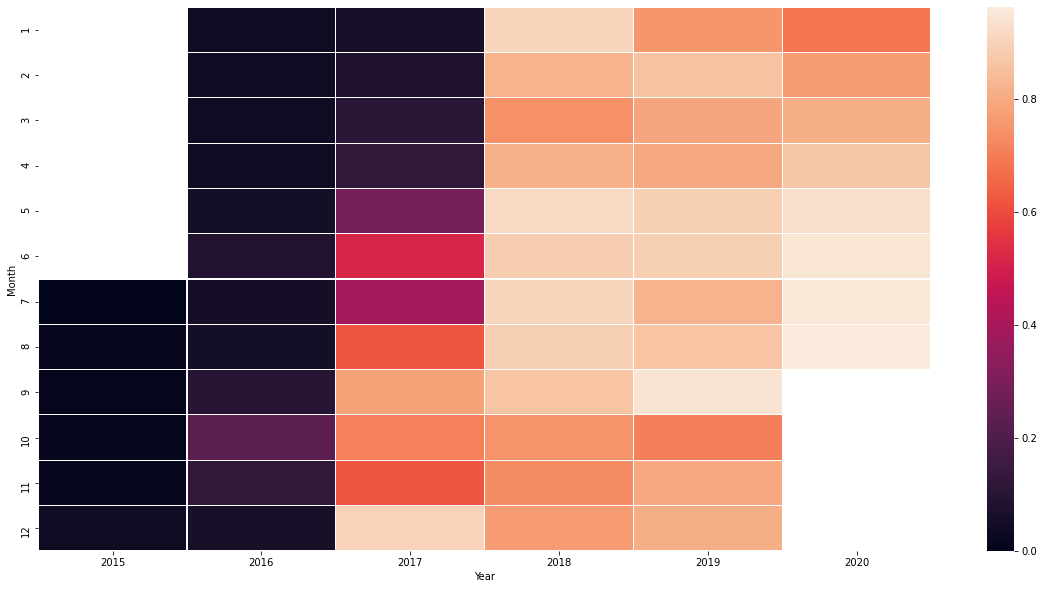

In [132]:
# heatmap by year and month
fig, ax = plt.subplots(figsize=(20,10))
plot_df = df[["Year","Month","Value"]].copy()
plot_df = plot_df.pivot_table(index="Month", columns="Year", values="Value",aggfunc="mean")
ax = sns.heatmap(plot_df, linewidths=0.1)

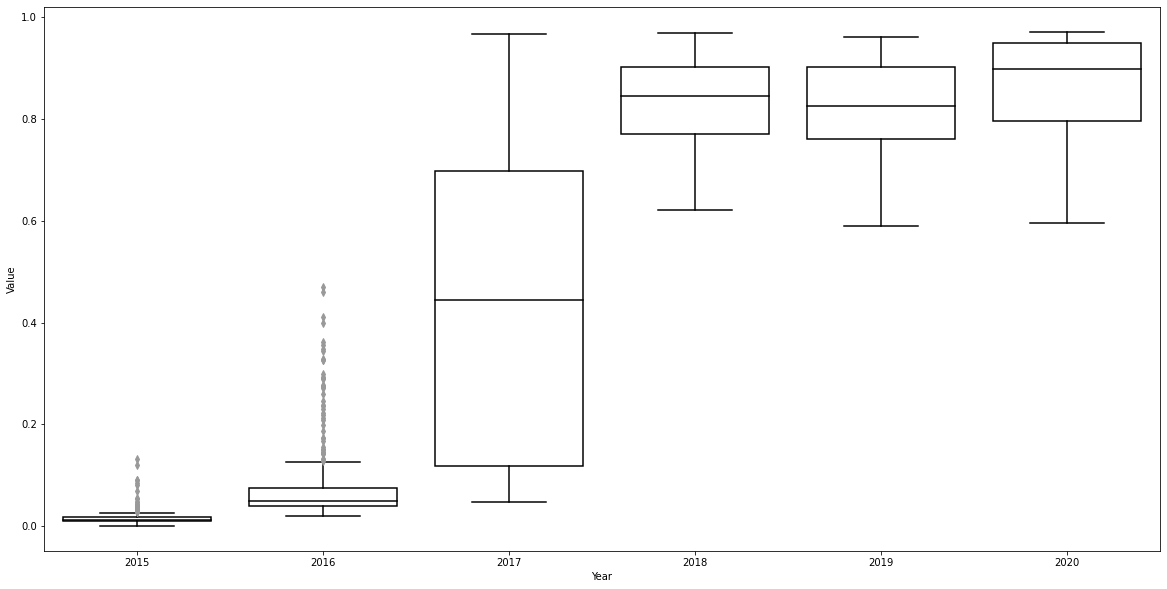

In [133]:
# Boxplots groupped by year
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(x=df["Year"],y=df["Value"], color='white')

# iterate over boxes (codes from https://stackoverflow.com/questions/43434020/black-and-white-boxplots-in-seaborn)
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')

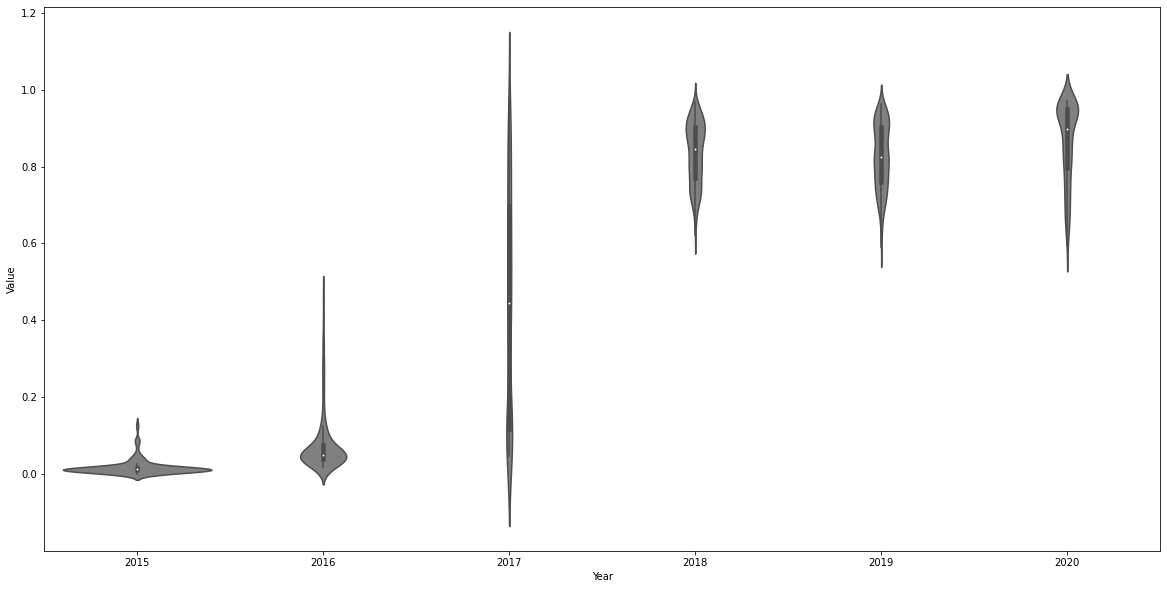

In [134]:
# violinplot groupped by year
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.violinplot(x=df["Year"],y=df["Value"], color='grey')

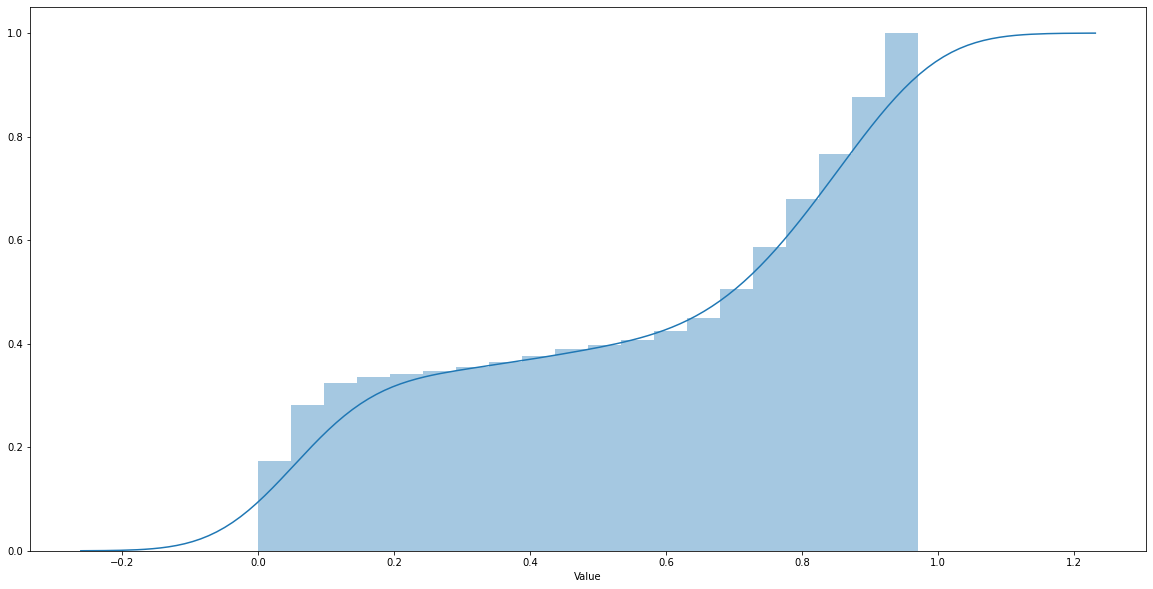

In [135]:
# ECDF
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.distplot(df["Value"], hist_kws={'cumulative': True}, kde_kws={'cumulative': True},bins=20)

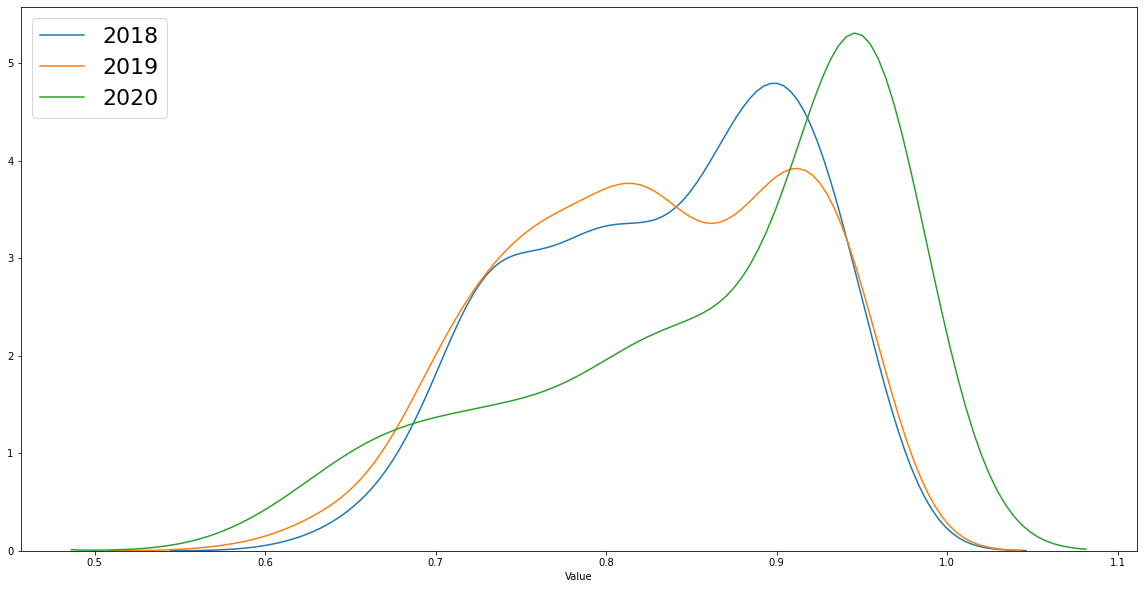

In [136]:
# ECDF by years
fig, ax = plt.subplots(figsize=(20,10))
for year in df.loc[df["Year"]>2017,"Year"].unique():
  sns.distplot(df.loc[df["Year"]==year,"Value"], hist=False, label = year)
  #legend_list.append(str(year))
ax.legend(loc='upper left', fontsize=22)

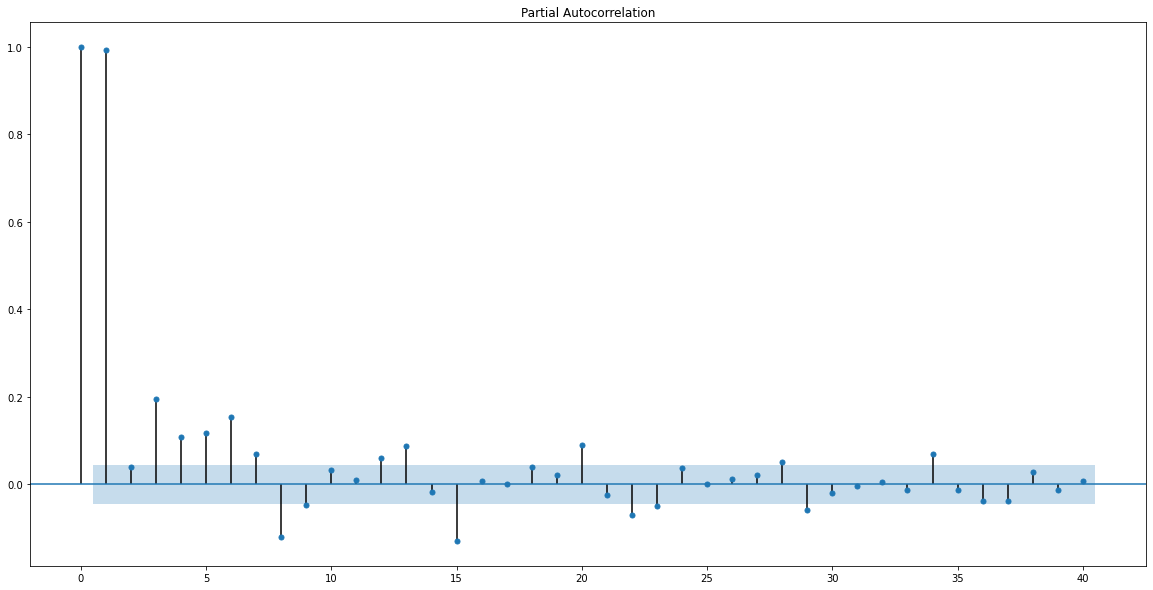

In [137]:
# partial auto correlation at daily
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(20,10))
plot_pacf(df["Value"].values, lags=40,ax=ax)
plt.show()

# Multivariate Plots

In [157]:
# load the dataset, don't need the date as UnixTimeStamp is given
data = []
to_include = ["export-verified-contracts.csv",
              "export-NetworkUtilization.csv",
              "export-GasUsed.csv",
              "export-GasLimit.csv",
              "export-TxGrowth.csv",
              "export-tokenerc-20txns.csv",
              "export-AddressCount.csv"]
for i in to_include:
    table = pd.read_csv(i,sep=",").iloc[:,1:]
    variable_name = i.split(".")[0].replace("export-","")
    table.columns = ["UnixTimeStamp",variable_name]
    data.append(table)

In [158]:
# construct a main df by inner merge on date (i.e. observations with missing values on any date are dropped)
df = data[0]
for i in range(1,len(data)):
    df = df.merge(data[i],on=["UnixTimeStamp"],how="inner")
df["Date"] = pd.to_datetime(df["UnixTimeStamp"],unit="s")
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.week

In [159]:
df.head()

,UnixTimeStamp,verified-contracts,NetworkUtilization,GasUsed,GasLimit,TxGrowth,tokenerc-20txns,AddressCount,Date,Year,Month,Week
0,1458777600,12,0.057,1626133605,4714155,36947,4911,130970,2016-03-24,2016,3,12
1,1458864000,2,0.046,1312008358,4713540,36762,2164,132066,2016-03-25,2016,3,12
2,1458950400,5,0.046,1332524164,4722269,36646,5508,133107,2016-03-26,2016,3,12
3,1459036800,1,0.029,825632165,4713640,29974,510,134131,2016-03-27,2016,3,12
4,1459123200,1,0.042,1184635969,4713570,33613,4227,135514,2016-03-28,2016,3,13


In [160]:
# export first 10 rows as table to latex
df[0:10].to_latex("T1.tex",index=False,columns=["Date","verified-contracts","NetworkUtilization"],float_format="%.3f")

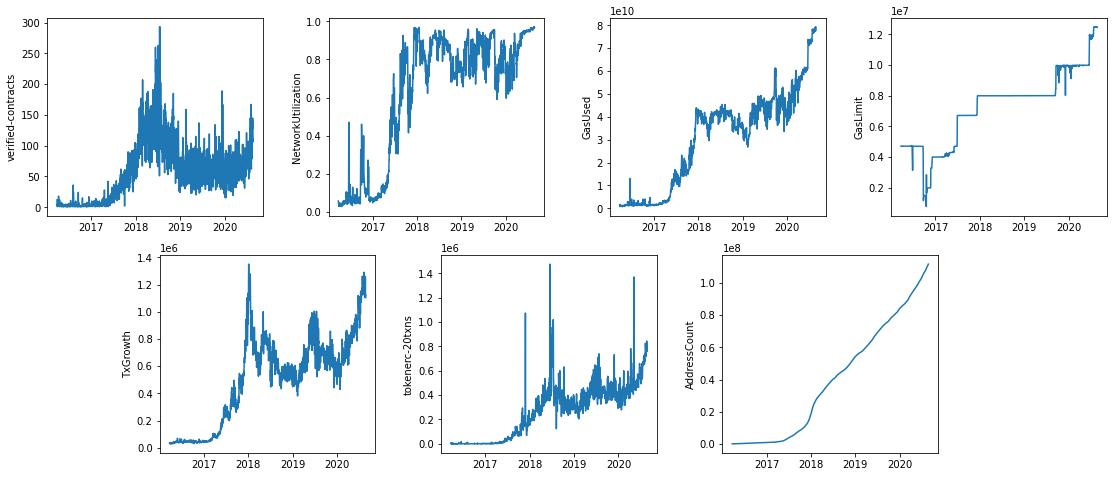

In [172]:
# multiple time series

fig = plt.subplots(figsize=(20, 8))

# Because there are 7 times series, I have to manually draw the frames to achieve better alignment.
gs = gridspec.GridSpec(2, 20, height_ratios=[1,1]) 
ax1 = plt.subplot(gs[0,0:4])
ax2 = plt.subplot(gs[0,5:9])
ax3 = plt.subplot(gs[0,10:14])
ax4 = plt.subplot(gs[0,15:19])
ax5 = plt.subplot(gs[1,2:6])
ax6 = plt.subplot(gs[1,7:11])
ax7 = plt.subplot(gs[1,12:16])
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7]

# plot in every subplot a time series
xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)

for i in range(0,7):
    axes[i].plot(df["Date"],df.iloc[:,i+1])
    axes[i].xaxis.set_major_locator(YearLocator())
    years_fmt = mdates.DateFormatter('%Y')
    axes[i].xaxis.set_major_formatter(years_fmt)
    axes[i].set_ylabel(df.iloc[:,i+1].name)

In [144]:
# correlation matrix
# maybe the correlation should be run on transformed variables (i.e. de-trended or first difference)
corr = df[["verified-contracts","NetworkUtilization","GasUsed","GasLimit","TxGrowth","tokenerc-20txns","AddressCount"]].corr()
corr

,verified-contracts,NetworkUtilization,GasUsed,GasLimit,TxGrowth,tokenerc-20txns,AddressCount
verified-contracts,1.000,0.707,0.646,0.592,0.683,0.642,0.442
NetworkUtilization,0.707,1.000,0.897,0.831,0.902,0.801,0.725
GasUsed,0.646,0.897,1.000,0.942,0.937,0.902,0.906
GasLimit,0.592,0.831,0.942,1.000,0.866,0.845,0.895
TxGrowth,0.683,0.902,0.937,0.866,1.000,0.823,0.764
tokenerc-20txns,0.642,0.801,0.902,0.845,0.823,1.000,0.858
AddressCount,0.442,0.725,0.906,0.895,0.764,0.858,1.000


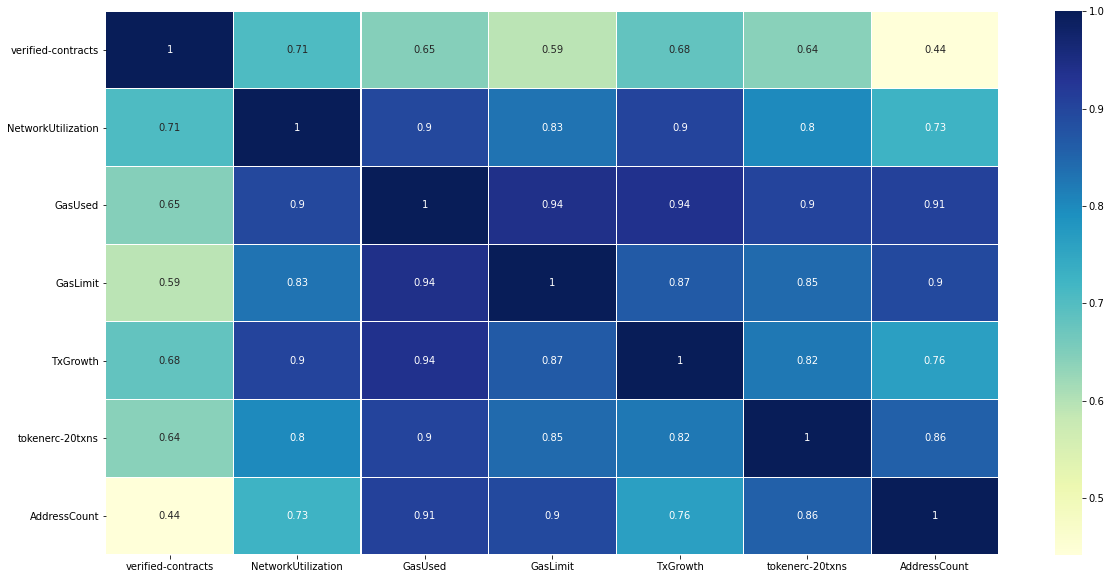

In [145]:
# correlation heatmap
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(corr, linewidths=0.1, cmap="YlGnBu", annot=True)

# 3D plots

In [148]:
# I use the subset from 2018 onwards
df = df.loc[df["Year"]>=2018,:]

In [149]:
df.head()

,UnixTimeStamp,verified-contracts,NetworkUtilization,GasUsed,GasLimit,TxGrowth,tokenerc-20txns,AddressCount,Date,Year,Month,Week
574,1514764800,48,0.842,39876127062,7996099,908945,175286,18673081,2018-01-01,2018,1,1
575,1514851200,46,0.928,42671435301,7996534,1153936,203644,18945115,2018-01-02,2018,1,1
576,1514937600,58,0.943,41794056176,7997271,1238030,190084,19268312,2018-01-03,2018,1,1
577,1515024000,58,0.948,41332879147,7998221,1349890,155054,19624038,2018-01-04,2018,1,1
578,1515110400,66,0.945,40379621205,7997843,1271577,173793,19970449,2018-01-05,2018,1,1


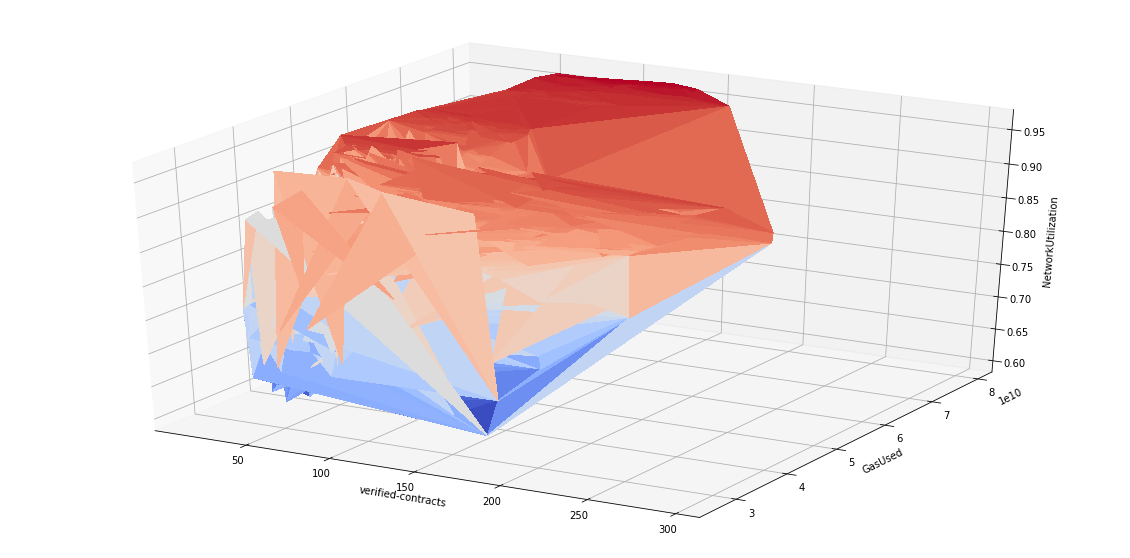

In [150]:
# surface plots
fig = plt.figure(figsize=(20,10))
ax=fig.gca(projection='3d')
surf = ax.plot_trisurf(df["verified-contracts"], df["GasUsed"], df["NetworkUtilization"],cmap=cm.coolwarm,linewidth=0, antialiased=False)
#ax.xaxis.set_major_locator(ticker.MaxNLocator(3,integer=True))
ax.set_xlabel("verified-contracts", color="k")
ax.set_ylabel("GasUsed", color="k")
ax.set_zlabel("NetworkUtilization", color="k")
#fig.colorbar(surf, shrink=0.5, aspect=5) #to include a color bar
plt.show()